<a href="https://colab.research.google.com/github/KacperKurzydlo/LiquidCrystalPhases/blob/main/LCP_100x100_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [40]:
!pip install tensorflow==2.8

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.__version__

'2.8.0'

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
path = '/content/drive/MyDrive/Praktyki/gotowe.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [44]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True,
                                        vertical_flip=True)


In [45]:
train_dataset = training_generator.flow_from_directory('/content/gotowe/train_set',
                                                       target_size = (100, 100),
                                                       batch_size = 10,
                                                       color_mode='rgb',
                                                       class_mode = 'categorical',
                                                       shuffle = True)

Found 11158 images belonging to 7 classes.


In [46]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [47]:
train_dataset.class_indices

{'nematyk': 0,
 'smektyk_C': 1,
 'smektyk_F': 2,
 'smektyk_GMosaic': 3,
 'smektyk_GSchliren': 4,
 'smektyk_H': 5,
 'smektyk_I': 6}

In [48]:
test_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

In [49]:
validation_dataset = val_generator.flow_from_directory('/content/gotowe/val_set',
                                                        target_size=(100, 100),
                                                        batch_size=1,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        shuffle=True) # set as validation data

Found 1395 images belonging to 7 classes.


In [50]:
L2 = 0.00001

In [51]:
test_datatset = test_generator.flow_from_directory('/content/gotowe/test_set',
                                                   target_size = (100, 100),
                                                   batch_size = 1,
                                                   color_mode='rgb',
                                                   class_mode = 'categorical',
                                                   shuffle = False)

Found 1396 images belonging to 7 classes.


In [52]:
initializer1 = tf.keras.initializers.HeNormal()
initializer2 = tf.keras.initializers.GlorotUniform()

In [53]:
network = Sequential()

network.add(Conv2D(filters=32, kernel_size=(6,6), activation = 'relu', input_shape = (100,100,3), kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=64, kernel_size=(5,5), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=128, kernel_size=(4,4), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=256, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=512, kernel_size=(2,2), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=1024, kernel_size=(1,1), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Flatten())

#network.add(Dropout(0.2))

network.add(Dense(units = 1024, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 512, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 256, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 128, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 64, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 32, activation = 'relu', kernel_initializer=initializer1, kernel_regularizer=tf.keras.regularizers.L1L2()))
network.add(BatchNormalization())
network.add(Dense(units = 7, activation = 'softmax', kernel_initializer=initializer2))
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 95, 95, 32)        3488      
                                                                 
 batch_normalization_24 (Bat  (None, 95, 95, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 47, 47, 64)        51264     
                                                                 
 batch_normalization_25 (Bat  (None, 47, 47, 64)       256       
 chNormalization)                                                
                                                      

In [54]:
from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=0.005)
opt = Adam()
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])


In [55]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001, patience = 20, verbose =1)
model_cp = ModelCheckpoint(filepath = 'best_model1.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1, factor=0.5, min_lr=0.00001)

In [56]:
history = network.fit_generator(train_dataset,
                                steps_per_epoch = 50,
                                validation_data = validation_dataset,
                                validation_steps = 50,
                                epochs=100,
                                callbacks=[es, model_cp, learning_rate_reduction])

Epoch 1/100


<ipython-input-56-d45876fe1552>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(train_dataset,


50/50 [==============================] - ETA: 0s - loss: 1.8775 - accuracy: 0.3100
Epoch 1: val_accuracy improved from -inf to 0.18000, saving model to best_model1.h5
50/50 [==============================] - 41s 769ms/step - loss: 1.8775 - accuracy: 0.3100 - val_loss: 4.9585 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 1.4288 - accuracy: 0.4540
Epoch 2: val_accuracy improved from 0.18000 to 0.22000, saving model to best_model1.h5
50/50 [==============================] - 40s 800ms/step - loss: 1.4288 - accuracy: 0.4540 - val_loss: 2.3459 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 1.3763 - accuracy: 0.5060
Epoch 3: val_accuracy did not improve from 0.22000
50/50 [==============================] - 42s 852ms/step - loss: 1.3763 - accuracy: 0.5060 - val_loss: 2.0921 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 1

In [57]:
predictions=network.predict(test_datatset)
predictions = np.argmax(predictions, axis=1)

In [58]:
from sklearn.metrics import accuracy_score
accuracy_score(test_datatset.classes, predictions)

0.8101719197707736

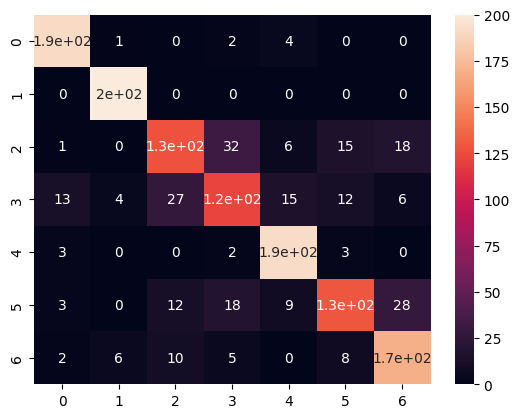

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_datatset.classes, predictions)
sns.heatmap(cm, annot=True);

In [60]:
from sklearn.metrics import classification_report
print(classification_report(test_datatset.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       198
           1       0.95      1.00      0.97       200
           2       0.72      0.64      0.68       200
           3       0.67      0.61      0.64       199
           4       0.85      0.96      0.90       200
           5       0.77      0.65      0.70       199
           6       0.76      0.84      0.80       200

    accuracy                           0.81      1396
   macro avg       0.80      0.81      0.80      1396
weighted avg       0.80      0.81      0.80      1396



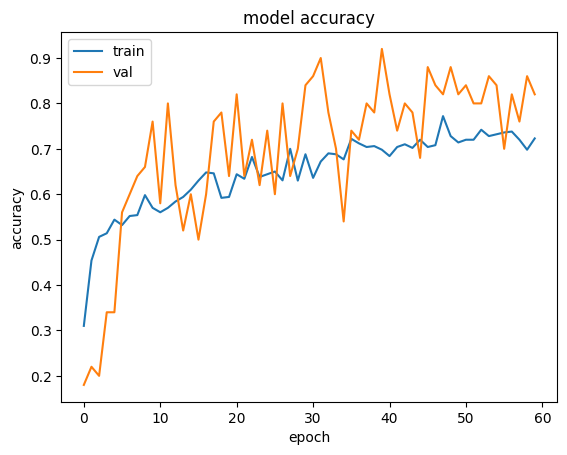

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

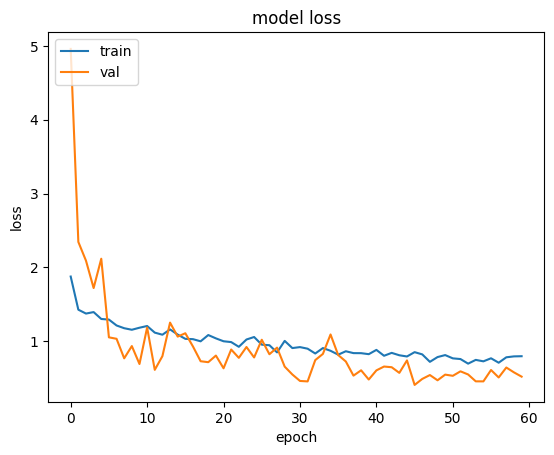

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model1.h5')

In [64]:
model.evaluate(test_datatset)

1396/1396 [==============================] - 39s 28ms/step - loss: 0.6605 - accuracy: 0.7486


[0.6604824066162109, 0.7485673427581787]

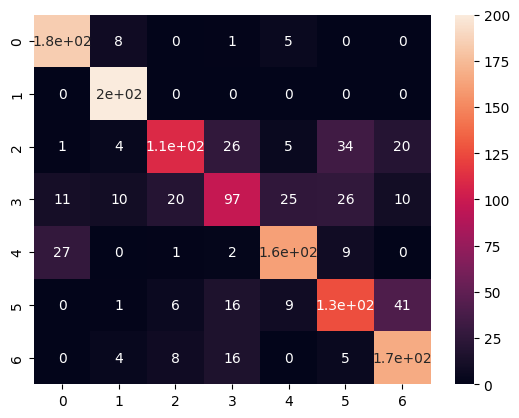

In [65]:
pred = model.predict(test_datatset)
pred = np.argmax(pred, axis=1)
cm = confusion_matrix(test_datatset.classes, pred)
sns.heatmap(cm, annot=True);

In [66]:
print(classification_report(test_datatset.classes, pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87       198
           1       0.88      1.00      0.94       200
           2       0.76      0.55      0.64       200
           3       0.61      0.49      0.54       199
           4       0.79      0.81      0.80       200
           5       0.63      0.63      0.63       199
           6       0.70      0.83      0.76       200

    accuracy                           0.75      1396
   macro avg       0.74      0.75      0.74      1396
weighted avg       0.74      0.75      0.74      1396



In [68]:
network.save('network.h5')

In [69]:
net = load_model('/content/network.h5')

In [70]:
net.evaluate(test_datatset)

1396/1396 [==============================] - 42s 30ms/step - loss: 0.5561 - accuracy: 0.8102


[0.5560574531555176, 0.810171902179718]

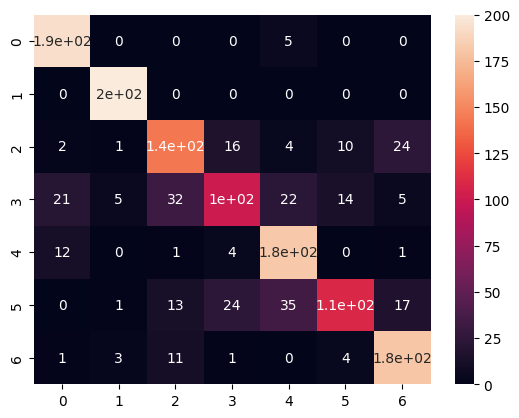

In [33]:
pre = net.predict(test_datatset)
pre = np.argmax(pre, axis=1)
cm = confusion_matrix(test_datatset.classes, pre)
sns.heatmap(cm, annot=True);

In [71]:
print(classification_report(test_datatset.classes, pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87       198
           1       0.88      1.00      0.94       200
           2       0.76      0.55      0.64       200
           3       0.61      0.49      0.54       199
           4       0.79      0.81      0.80       200
           5       0.63      0.63      0.63       199
           6       0.70      0.83      0.76       200

    accuracy                           0.75      1396
   macro avg       0.74      0.75      0.74      1396
weighted avg       0.74      0.75      0.74      1396

